In [1]:
import sys
import os
import imp
import pickle as pickle
import numpy as np

from optparse import OptionParser
from demos.diffusion import ContaminantTransportModel
from collections import Iterable
from paper.examples.diffusion_common import *
from vuq import *

In [2]:
def make_model():
    num_dim = 3

    log_prior = PDFCollection([UniformND(2),
                               MultivariateNormal([[-1.]])])
    y = load_diffusion_data()
    solver = ContaminantTransportModel()
    log_like = IsotropicGaussianLikelihood(y, solver)
    log_p = Joint(log_like, log_prior)

    return locals()

In [3]:
def parse_expr_callback(option, opt, value, parser):
    if value is not None:
        setattr(parser.values, option.dest, eval(value))


def parse_list_callback(option, opt, value, parser):
    if value is not None:
        value = [float(x) for x in value.split(',')]
        if len(value) == 0:
            value = value[0] 
    setattr(parser.values, option.dest, value)

    
def convert_to_list(l, n):
    if not isinstance(l, Iterable):
        l = [l] * n
    return l


def initialize_bounds(l, u, n):
    l = convert_to_list(l, n)
    u = convert_to_list(u, n)
    b = tuple((l[i], u[i]) for i in range(n))
    return b


def main(options):
    model = options.model
    log_p = model['log_p']
    log_prior = model['log_prior']
    comp = [MultivariateNormal(log_prior.sample().flatten())
            for i in range(options.num_comp)]
    log_q = MixtureOfMultivariateNormals(comp)
    if options.mu_init is not None:
        log_q.mu = options.mu_init
        print (str(log_q))
    entropy = eval(options.entropy_approximation + '()')
    expectation_functional = eval(options.expectation_functional + '(log_p)')
    elbo = EvidenceLowerBound(entropy, expectation_functional)
    optimizer = Optimizer(elbo)
    mu_bounds = initialize_bounds(options.mu_lower_bound, options.mu_upper_bound, log_q.num_dim)
    C_bounds = initialize_bounds(options.C_lower_bound, options.C_upper_bound, log_q.num_dim)
    print ('mu_bounds', mu_bounds)
    print ('C_bounds', C_bounds)
    output_file = options.output
    if output_file is None:
        output_file = os.path.abspath('4_corners_num_comp=' + str(options.num_comp) + '.pcl')
    if os.path.exists(output_file) and options.force:
        print ('-', output_file, 'exists')
        print ('- I am removing it')
        os.remove(output_file)
    if os.path.exists(output_file):
        print ('- I am not repeating the calculations')
        with open(output_file, 'rb') as fd:
            results = pickle.load(fd)
            L = results['L']
            log_q = results['log_q']
            nfev = results['nfev']
    else:
        L, nfev = optimizer.optimize(log_q,
                                     tol=options.tol,
                                     max_it=options.max_it,
                                     mu_bounds=mu_bounds,
                                     C_bounds=C_bounds,
                                     full_mu=options.optimize_full_mu)
        print (str(elbo))
        results = {}
        results['L'] = L
        results['log_q'] = log_q
        results['nfev'] = nfev
        with open(output_file, 'wb') as fd:
    w = log_q.w
    mu = log_q.mu
    C = log_q.C
    c = np.vstack([np.diag(C[i, :, :]) for i in range(log_q.num_comp)])
    x_m = np.mean(w * mu, axis=0)
    samples = log_q.sample(options.std_samples)
    x_s = np.std(samples, axis=0)
    x_05 = np.percentile(samples, 5, axis=0)
    x_95 = np.percentile(samples, 95, axis=0)
    print ('{0:10s} {1:10s} {2:10s}'.format('Parameter', 'Mean', 'Std.'))
    print ('-' * 32)
    for i in range(log_q.num_dim):
        print ('{0:10s} {1:4.6f} +-{2:2.6f}'.format('x_' + str(i+1), x_m[i], 1.96 * x_s[i]))
    for i in range(log_q.num_dim):
        print ('(%1.3f, %1.3f)' % (x_05[i], x_95[i]))
    print ('Number of evaluations:', nfev)

In [4]:
def initialize_model(model_file, model_name='Model', comm=None):
    rank, size = get_rank_size(comm)
    print_once('Initializing the %s.\n' % model_name, comm=comm)
    print_once('-------------------------\n', comm=comm)
    for i in range(size):
        if rank == i:
            try:
                model = imp.load_source('', model_file)
            except Exception as e:
                signal_fatal_error('I couldn\'t load the %s.\n' % model_name,
                                   comm=comm, e=e)
            print_rank(i, 'initialized %s.\n' % model_name)
        mpi_wait(comm)
    print_once('Done.\n'
               '-------------------------\n', comm=comm)
    return model


def initialize_native_model(model_file, model_name='Native Model', comm=None):
    return initialize_model(model_file, model_name=model_name, comm=comm).make_model()

In [5]:
from easydict import EasyDict as edict

options = edict({'model':make_model(),
                 'entropy_approximation': 'FirstOrderEntropyApproximation',
                 'expectation_functional': 'ThirdOrderExpectationFunctional',
                 'num_comp': 1,
                 'mu_lower_bound': [0] * 2 + [None],
                 'mu_upper_bound': [1] * 2 + [None],
                 'C_lower_bound': 1e-6,
                 'C_upper_bound': [10] * 3,
                 'max_it': 30,
                 'tol': 1e-2,
                 'std_samples': 1000,
                 'mu_init': None,
                 'output': None,
                 'force': None,
                 'optimize_full_mu': None})
main(options)

mu_bounds ((0, 1), (0, 1), (None, None))
C_bounds ((1e-06, 10), (1e-06, 10), (1e-06, 10))
mu [0.10624923 0.28295449 0.23950863]
mu [ 0.10004374  0.26642854 -0.76033556]
mu [ 0.0752218   0.20032472 -4.75971228]
mu [ 0.09215567  0.24542167 -2.03128161]
mu [  0.           0.         -16.38204157]
mu [ 0.06222128  0.16570276 -6.69275633]
mu [ 0.08323192  0.22165663 -3.42091591]
mu [ 0.08761915  0.23334036 -2.73772234]
mu [ 0.          0.19408364 -3.18326367]
mu [ 0.06726544  0.22422112 -2.84122051]
mu [ 0.03128159  0.22733201 -3.0587538 ]
mu [ 0.06371937  0.22452769 -2.86265758]
mu [ 0.0656707   0.22435899 -2.8508612 ]
mu [ 0.06713479  0.22486312 -2.93920283]
mu [ 0.06398534  0.22245887 -2.90513579]
mu [ 0.06591281  0.22403688 -2.89771608]
mu [ 0.06542703  0.22365165 -2.90479948]
mu [ 0.06538535  0.22363119 -2.90450505]
mu [ 0.06539037  0.22363276 -2.90452982]
mu [ 0.06539047  0.22363298 -2.90453203]
      fun: -24.746012530391514
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
   

In [ ]:
parser = OptionParser()
parser.add_option('-m', '--model', metavar='FILE', dest='model', default=make_model(),
                  help='specify the file containing the native model')
parser.add_option('--entropy-approximation', type=str, dest='entropy_approximation',
                  default='FirstOrderEntropyApproximation',
                  help='specify the entropy approximation to be used')
parser.add_option('--expectation-functional', type=str, dest='expectation_functional',
                  default='ThirdOrderExpectationFunctional',
                  help='specify the expectation functional to be used')
parser.add_option('--num-comp', type=int, dest='num_comp', default=2,
                  help='specify the number of components that you want to use')
parser.add_option('--mu-lower-bound', type=str, dest='mu_lower_bound', default=[0]*2 + [None], action='callback',
                  callback=parse_expr_callback,
                  help='specify the lower bound for mu')
parser.add_option('--mu-upper-bound', type=str, dest='mu_upper_bound', default=[1]*2 + [None], action='callback',
                  callback=parse_expr_callback, 
                  help='specify the upper bound for mu') 
parser.add_option('--C-lower-bound', type=str, dest='C_lower_bound', action='callback',
                  callback=parse_expr_callback, default=1e-6,
                  help='specify the lower bound for C')
parser.add_option('--C-upper-bound', type=str, dest='C_upper_bound', action='callback',
                  callback=parse_expr_callback, default=[10]*3,
                  help='specify the upper bound for C')
parser.add_option('--max-it', type=int, dest='max_it', default=30,
                  help='specify the maximum number of iterations')
parser.add_option('--tol', type=float, dest='tol', default=1e-2,
                  help='specify the tolerance')
parser.add_option('--std-samples', type=int, dest='std_samples', default=1000,
                  help='specify the number of samples used in the estimation of the std')
parser.add_option('--optimize-full-mu', action='store_true', dest='optimize_full_mu',
                  help='optimize all the mus simultaneously')
parser.add_option('-f', '--force', action='store_true', dest='force',
                  help='force the calculation')
parser.add_option('-o', '--output', metavar='FILE', dest='output',
                  help='specify the output file')
parser.add_option('--mu-init', type=str, dest='mu_init', action='callback',
                  callback=parse_expr_callback,
                  help='specify the initial point for mu num_comp x num_dim')
options, args = parser.parse_args()
main(options)

mu_bounds ((0, 1), (0, 1), (None, None))
C_bounds ((1e-06, 10), (1e-06, 10), (1e-06, 10))
mu [ 0.558481    0.26617735 -1.34114712]
mu [ 0.52231432  0.24893997 -0.34195002]
mu [ 0.34724981  0.23080683 -0.8747582 ]


# Graphs

In [6]:
from optparse import OptionParser
from paper.examples.diffusion_common import *
from paper.examples import diffusion_model
import matplotlib.pyplot as plt
import pickle as pickle
import tables as tb
import pandas as pd
from scipy import stats
from vuq import MultivariateNormal, MixtureOfMultivariateNormals


def main(options):
    data = load_diffusion_data()
    model = diffusion_model.make_model()
    model = model['solver']
    
    with open(options.var_file, 'rb') as fd:
        var_results = pickle.load(fd)
    log_q = var_results['log_q']

    w = log_q.w
    mu =log_q.mu
    C = log_q.C
    c = np.vstack([np.diag(C[i, :, :]) for i in range(log_q.num_comp)])
    
    x_m_var = np.mean(mu * w[:, None], axis=0)
    samples_var = log_q.sample(options.var_samples)
    x_s_var = np.std(samples_var, axis=0)
    
    for i in range(mu.shape[1]):
        fig = plt.figure( figsize=(20, 10))
        ax = fig.add_subplot(111)
        x_min = 0.001
        x_max = 0.3
        x_i = np.linspace(x_min, x_max, 100)
        xx_i = np.log(x_i)[:, None] if i == 2 else x_i[:, None]
        
        # Create a 1D mixture
        comp = [MultivariateNormal([[mu[j, i]]], C=[[c[j, i]]])
                for j in range(log_q.num_comp)]
        log_q_i = MixtureOfMultivariateNormals(comp)
        y_i = np.exp(log_q_i(xx_i)) / (x_i if i == 2 else 1.)
        ax.plot(x_i, y_i, 'r-', linewidth=2)
        
        if i == 2:
            ax.plot([0.05] * 100, np.linspace(0, 50, 100), 'g--', linewidth=2)
        elif i == 0:
            ax.plot([0.09] * 100, np.linspace(0, options.max_true_pxi, 100), 'g--', linewidth=2)
        else:
            ax.plot([0.23] * 100, np.linspace(0, options.max_true_pxi, 100), 'g--', linewidth=2)

        #ax.hist(samples_var[:, i], alpha=0.5, normed=True)
        name  = '\\xi_{%d}' % (i + 1) if i < 2 else '\sigma'
        xlabel = '$' + name + '$'
        ylabel = '$p(' + name + '|y)$'
        ax.set_xlabel(xlabel, fontsize=26)
        ax.set_ylabel(ylabel, fontsize=26)
        plt.setp(ax.get_xticklabels(), fontsize=26)
        plt.setp(ax.get_yticklabels(), fontsize=26)

        if i == 0:
            leg = plt.legend(['VAR ($L=%d$)' % log_q.num_comp, 'True value', 'MCMC (MALA)'], loc='best')
            plt.setp(leg.get_texts(), fontsize=26)
        if i == 2:
            leg = plt.legend(['VAR ($L=%d$)' % log_q.num_comp, 'True noise', 'MCMC (MALA)'], loc='best')
            plt.setp(leg.get_texts(), fontsize=26)
        if i == 5:
            ax.xaxis.set_major_locator(plt.MaxNLocator(6))
        plt.tight_layout()
        png_file = 'result_4_corners_input_' + str(i) + '.png'
        print ('- writing', png_file)
        plt.savefig(png_file)
        del fig
    

- writing result_4_corners_input_0.png
- writing result_4_corners_input_1.png
- writing result_4_corners_input_2.png


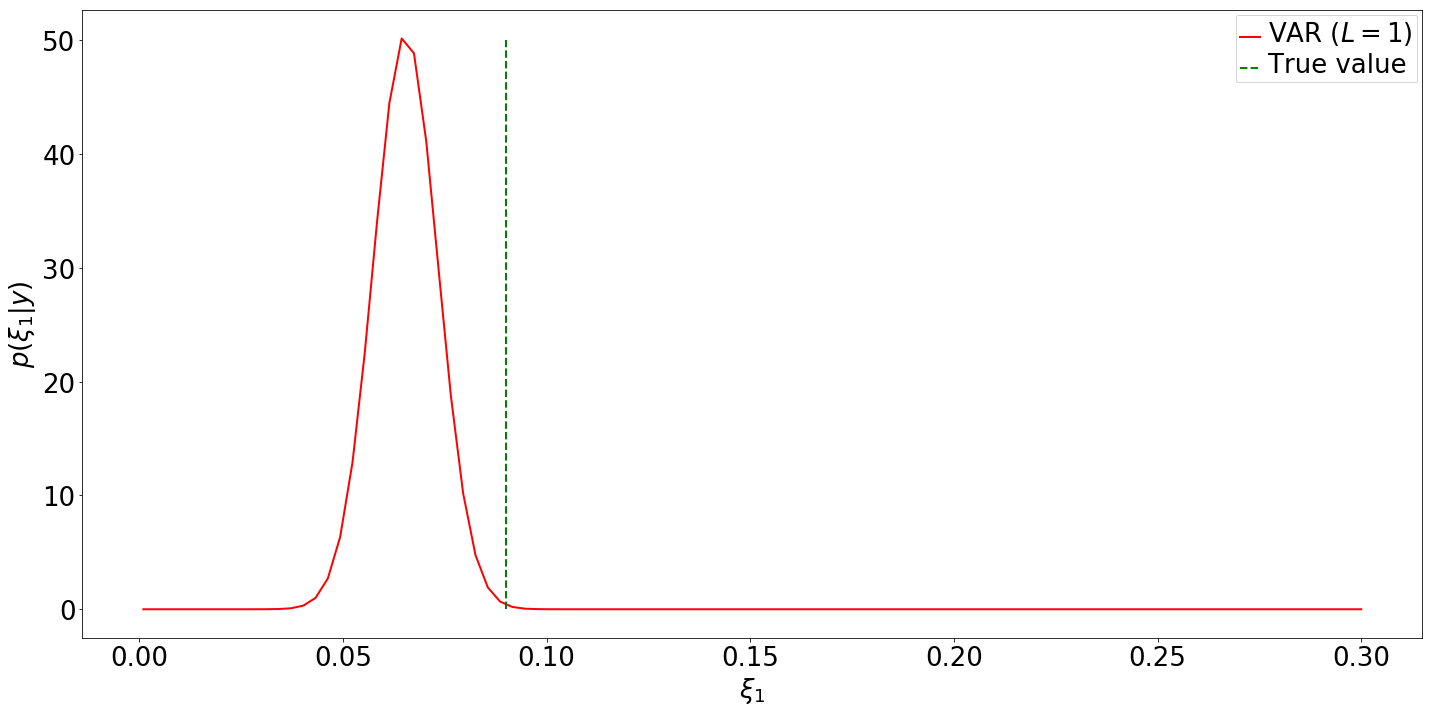

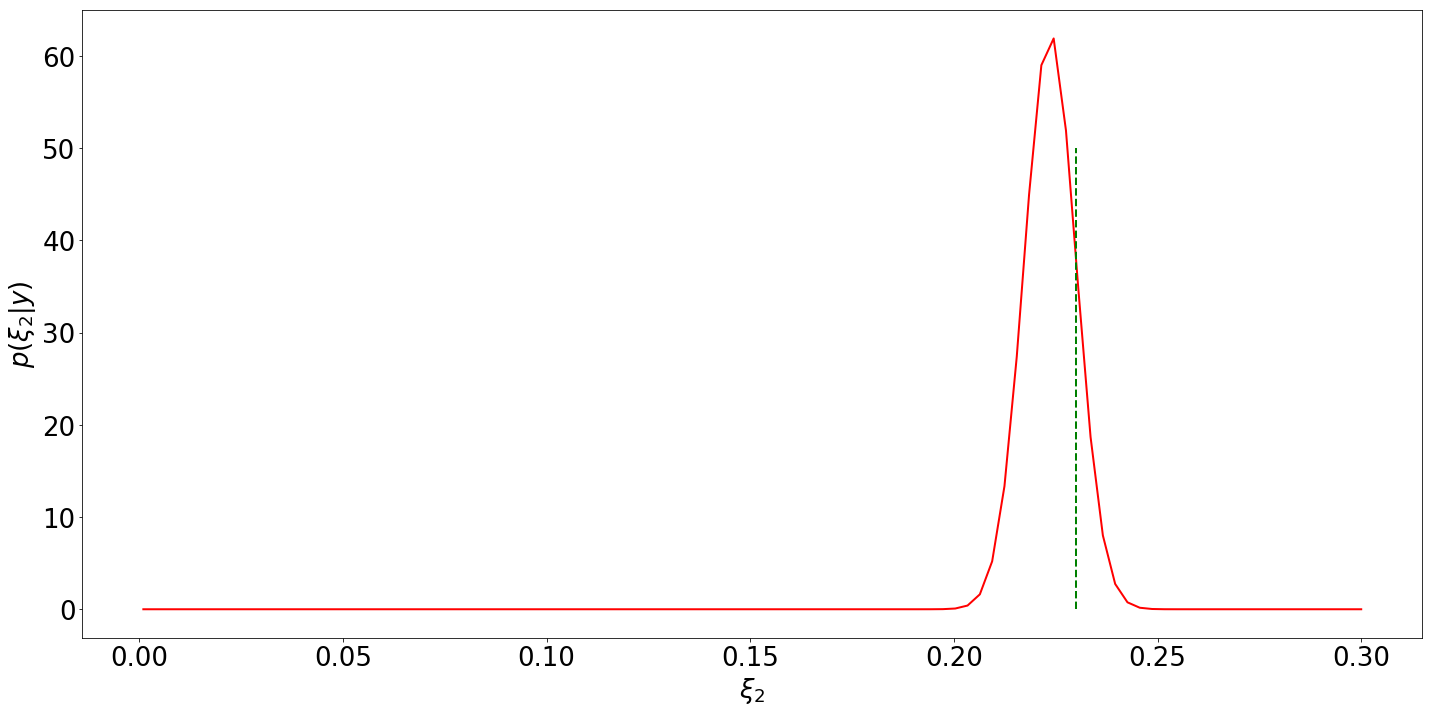

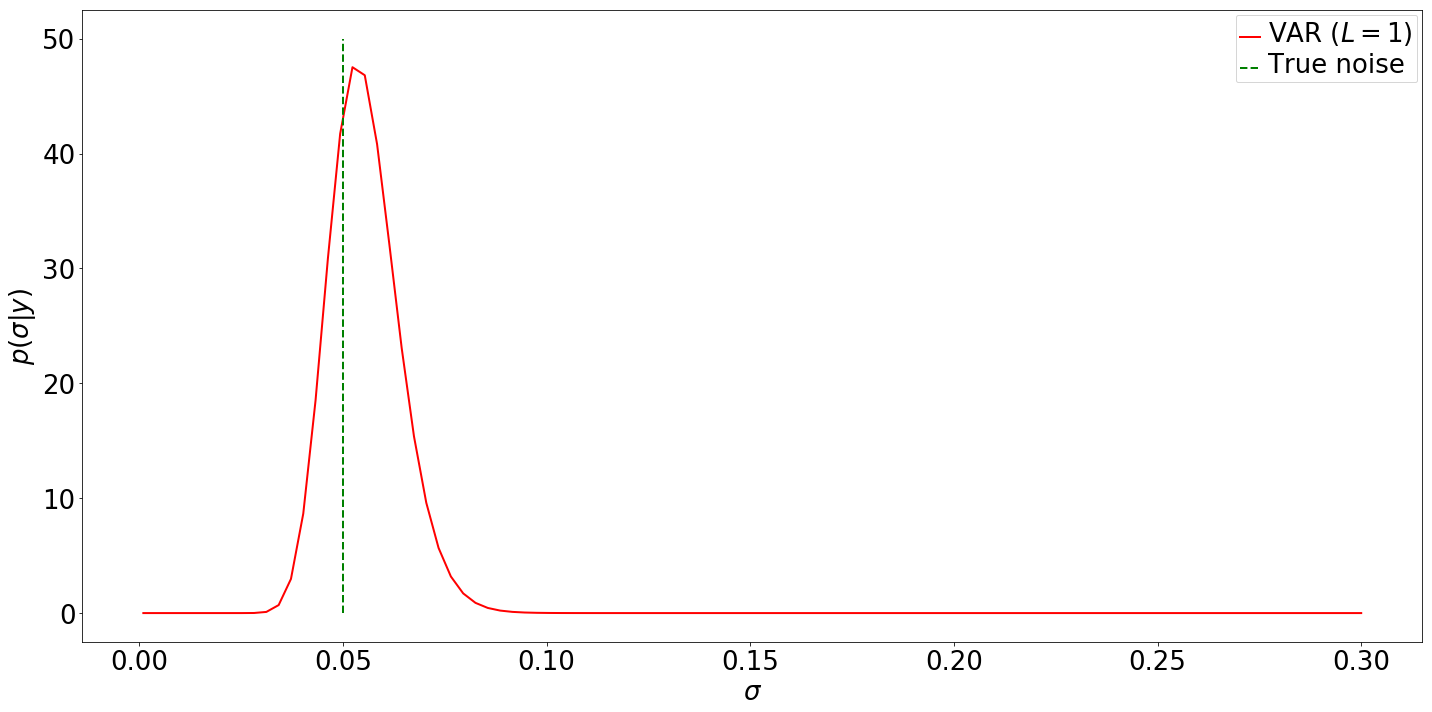

In [7]:
from easydict import EasyDict as edict

options = edict({'var_file':'C:\\Users\\Fedor\\Documents\\GitHub\\variational-reformulation-of-inverse-problems\\4_corners_num_comp=1.pcl',
                 'num_samples':10000,
                 's':100,
                 'thin':1,
                 'max':-1,
                 'var_samples':10000,
                 'rolling':100,
                 'max_true_pxi':50.})
main(options)